In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

c:\users\ankbz.desktop-9m3blv3\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\wheel\pep425tags.py:75: RuntimeWarning: Config variable 'Py_DEBUG' is unset, Python ABI tag may be incorrect
  warn=(impl == 'cp')):
c:\users\ankbz.desktop-9m3blv3\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\wheel\pep425tags.py:79: RuntimeWarning: Config variable 'WITH_PYMALLOC' is unset, Python ABI tag may be incorrect
  warn=(impl == 'cp')):


In [149]:
#Loading packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset, TensorDataset, DataLoader
from tqdm import tqdm 
import codecs
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

# Fix the seeds to get consistent results
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [16]:
from imblearn.over_sampling import RandomOverSampler

In [306]:
epochs=20
BATCH_SIZE = 256

In [307]:
train_data = pd.read_csv('dataset/offenseval-training-v1.tsv', sep="\t", header=0)
train_data.head(20)

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,NaN
7,52415,@USER was literally just talking about this lo...,OFF,TIN,GRP
8,45157,@USER Buy more icecream!!!,NOT,NaN,NaN
9,13384,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,IND


In [612]:
#Load dataset
train_data = pd.read_csv('dataset/offenseval-training-v1.tsv', sep="\t", header=0).values
train_sents_a = np.array(train_data[:,1].astype(str))

# Integer labeling
# NOT : 0, OFF : 1
_, train_label_a = np.unique(train_data[:,2].astype(str), return_inverse=True)
#TIN : 0, UNT : 1, nan: 2
_, train_label_b = np.unique(train_data[:,3].astype(str), return_inverse=True)
#GRP: 0, IND : 1, OTH: 2, nan: 3
_, train_label_c = np.unique(train_data[:,4].astype(str), return_inverse=True)

#TIN : 0, UNT : 1
train_sents_b = np.delete(train_sents_a, np.nonzero(train_label_b == 2), axis=0)
train_label_b = np.delete(train_label_b, np.nonzero(train_label_b == 2), axis=0)

#GRP: 0, IND : 1, OTH: 2
train_sents_c = np.delete(train_sents_a, np.nonzero(train_label_c == 3), axis=0)
train_label_c = np.delete(train_label_c, np.nonzero(train_label_c == 3), axis=0)

# Print out the samples for each class labels
unique, counts = np.unique(train_label_a, return_counts=True)
print(np.asarray((unique, counts)).T)
unique, counts = np.unique(train_label_b, return_counts=True)
print(np.asarray((unique, counts)).T)
unique, counts = np.unique(train_label_c, return_counts=True)
print(np.asarray((unique, counts)).T)

# Limited by the number of data, we oversample rather than downsample the data to make sure the classes in task B and C are balanced.
rus = RandomOverSampler(random_state=0)
train_sents_b, train_label_b = rus.fit_resample(train_sents_b.reshape(-1, 1), train_label_b)
train_sents_c, train_label_c = rus.fit_resample(train_sents_c.reshape(-1, 1), train_label_c)

train_sents_b = train_sents_b.reshape(-1, )
train_sents_c = train_sents_c.reshape(-1, )

print('train_sents_a shape: ', train_sents_a.shape)
print('train_label_a shape: ', train_label_a.shape)
print('train_sents_b shape: ', train_sents_b.shape)
print('train_label_b shape: ', train_label_b.shape)
print('train_sents_c shape: ', train_sents_c.shape)
print('train_label_c shape: ', train_label_c.shape)

# Print out the samples for each class labels
unique, counts = np.unique(train_label_a, return_counts=True)
print(np.asarray((unique, counts)).T)
unique, counts = np.unique(train_label_b, return_counts=True)
print(np.asarray((unique, counts)).T)
unique, counts = np.unique(train_label_c, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 8840]
 [   1 4400]]
[[   0 3876]
 [   1  524]]
[[   0 1074]
 [   1 2407]
 [   2  395]]
train_sents_a shape:  (13240,)
train_label_a shape:  (13240,)
train_sents_b shape:  (7752,)
train_label_b shape:  (7752,)
train_sents_c shape:  (7221,)
train_label_c shape:  (7221,)
[[   0 8840]
 [   1 4400]]
[[   0 3876]
 [   1 3876]]
[[   0 2407]
 [   1 2407]
 [   2 2407]]


In [544]:
# For test set for submission
def getEvaTensor(test_data, word2idx, max_len):
    place_hold = torch.empty((1,1))
    tokenized_corpus = get_tokenized_corpus(test_data)
    test_sent_tensor, _ = get_model_inputs(tokenized_corpus, word2idx, place_hold, max_len)
    
    return test_sent_tensor

In [587]:
# For test set for submission
eva_data_a = getEvaTensor(np.array(pd.read_csv('dataset/testset-taska.tsv', sep="\t", header=0).astype(str))[:, 1], word2idx_a, max_len_a)
eva_data_b = getEvaTensor(np.array(pd.read_csv('dataset/testset-taskb.tsv', sep="\t", header=0).astype(str))[:, 1], word2idx_b, max_len_b)
eva_data_c = getEvaTensor(np.array(pd.read_csv('dataset/test_set_taskc.tsv', sep="\t", header=0).astype(str))[:, 1], word2idx_c, max_len_c)

eva_id_a = np.array(pd.read_csv('dataset/testset-taska.tsv', sep="\t", header=0).astype(str))[:, 0]
eva_id_b = np.array(pd.read_csv('dataset/testset-taskb.tsv', sep="\t", header=0).astype(str))[:, 0]
eva_id_c = np.array(pd.read_csv('dataset/test_set_taskc.tsv', sep="\t", header=0).astype(str))[:, 0]

print('eva_data_a shape: ', eva_data_a.shape)
print('eva_data_b shape: ', eva_data_b.shape)
print('eva_data_c shape: ', eva_data_c.shape)

print('eva id a shape: ', eva_id_a.shape)
print('eva id b shape: ', eva_id_b.shape)
print('eva id c shape: ', eva_id_c.shape)

eva_data_a shape:  torch.Size([860, 105])
eva_data_b shape:  torch.Size([240, 103])
eva_data_c shape:  torch.Size([213, 103])
eva id a shape:  (860,)
eva id b shape:  (240,)
eva id c shape:  (213,)


In [310]:
def get_tokenized_corpus(corpus):
    
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    for sentence in corpus:
        sentence = re.sub(r'([A-Z])', lambda pat: pat.group(1).lower(), sentence)
        sentence = re.findall(r'\w+', sentence)
        tokenized_corpus.append(sentence)
 
    return tokenized_corpus

In [311]:
def get_word2idx(tokenized_corpus):
    vocabulary = []
    for sentence in tokenized_corpus:
        for token in sentence:
            if token not in vocabulary:
                vocabulary.append(token)
  
    word2idx = {w: idx+1 for (idx, w) in enumerate(vocabulary)}
    # we reserve the 0 index for the placeholder token
    word2idx['<pad>'] = 0
 
    return word2idx

In [312]:
def get_model_inputs(tokenized_corpus, word2idx, labels, max_len):

    # we index our sentences
    vectorized_sents = [[word2idx[tok] for tok in sent if tok in word2idx] for sent in tokenized_corpus]
 
    # we create a tensor of a fixed size filled with zeroes for padding
    sent_tensor = Variable(torch.zeros((len(vectorized_sents), max_len))).long()  
    sent_lengths = [len(sent) for sent in vectorized_sents]
  
    # we fill it with our vectorized sentences 
    for idx, (sent, sentlen) in enumerate(zip(vectorized_sents, sent_lengths)):
        sent_tensor[idx, :sentlen] = torch.LongTensor(sent)
    
    label_tensor = torch.FloatTensor(labels)
  
    return sent_tensor, label_tensor

In [313]:
def getDataLoaders(sents, label, test_size=0.2):
    tokenized_corpus = get_tokenized_corpus(sents)
    sent_lengths = [len(sent) for sent in tokenized_corpus]
    max_len = np.max(np.array(sent_lengths))    
    word2idx = get_word2idx(tokenized_corpus)
    sent_tensor, label_tensor = get_model_inputs(tokenized_corpus, word2idx, label, max_len)
    
    train_idx, valid_idx= train_test_split(np.arange(len(label_tensor)), test_size=test_size, random_state=SEED, shuffle=True, stratify = label)
    valid_idx, test_idx= train_test_split(valid_idx, test_size=0.5, random_state=SEED, shuffle=True)
    
    dataset = TensorDataset(sent_tensor, label_tensor)
    train_set = Subset(dataset, train_idx)
    valid_set = Subset(dataset, valid_idx)
    test_set = Subset(dataset, test_idx)
 
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
    
    return train_loader, valid_loader, test_loader, max_len, word2idx

In [315]:
# Data loader for training, validation and test
train_a_loader, valid_a_loader, test_a_loader, max_len_a, word2idx_a = getDataLoaders(train_sents_a, train_label_a, 0.4)
train_b_loader, valid_b_loader, test_b_loader, max_len_b, word2idx_b = getDataLoaders(train_sents_b, train_label_b, 0.4)
train_c_loader, valid_c_loader, test_c_loader, max_len_c, word2idx_c = getDataLoaders(train_sents_c, train_label_c, 0.4)

In [316]:
print(len(train_a_loader.dataset))
print(len(valid_a_loader.dataset))
print(len(test_a_loader.dataset))

7944
2648
2648


In [318]:
def f_measure(output, gold):
    output = output >= 0.5
    output = output.cpu().numpy()
    gold = gold.cpu().numpy()

    recall, precision, fscore, _ = precision_recall_fscore_support(output, gold, average='weighted')
    
    return recall, precision, fscore
    


In [319]:
 def accuracy_binary(output, target):
    
    correct = torch.sum((output >= 0.5).float() == target.float(), dtype = torch.float)
    acc = correct / len(target)
 
    return acc

In [320]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

wvecs = np.zeros((len(word2idx_a), 100))

with codecs.open('glove.twitter.27B.100d.txt', 'r','utf-8') as f: 
    index = 0
    for line in tqdm(f.readlines()):
        if len(line.strip().split()) > 3:
            word = line.strip().split()[0]
        if word in word2idx_a:
            (word, vec) = (word, list(map(float,line.strip().split()[1:])))
            idx = word2idx_a[word]
            wvecs[idx] = vec

#model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

100%|█████████████████████████████████████████████████████████████████████| 1193518/1193518 [00:23<00:00, 50706.85it/s]


In [321]:
def train_model(model, train_loader, valid_loader, test_loader):  
    for epoch in range(1, epochs+1):
        
        epoch_loss = 0
        epoch_acc = 0
        valid_loss = 0
        valid_acc = 0
        test_loss = 0
        test_acc = 0

        recall = 0
        precision = 0
        fscore = 0
        
        count_train = 0
        count_valid = 0
        count_test = 0
        
        model.train()
       
        #iterate over batches
        for batch in train_loader:
            
            #place on the GPU
            #feature, target = batch.text.cuda(), batch.label.cuda()
            
            feature, target = batch
            
            feature = feature.to('cuda')
            target = target.to('cuda')
 
            optimizer.zero_grad()
            predictions = model(feature).squeeze(1)
             
            loss = loss_fn(predictions, target)
            acc = accuracy_binary(predictions, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            count_train += 1
        
        with torch.no_grad():
            for batch_valid in valid_loader:
                feature_valid, target_valid = batch_valid
                
                feature_valid = feature_valid.to('cuda')
                target_valid = target_valid.to('cuda')
            
                predictions_valid = model(feature_valid).squeeze(1)
                loss = loss_fn(predictions_valid, target_valid)
                acc = accuracy_binary(predictions_valid, target_valid)
                valid_loss += loss.item()
                valid_acc += acc.item()
                count_valid += 1
            
        valid_loss = valid_loss /count_valid
        valid_acc = valid_acc /count_valid
        epoch_loss = epoch_loss /count_train
        epoch_acc = epoch_acc /count_train
        
        print('Epoch: {}. Train Loss: {:.3f}. Train Accuracy: {:.3f}  Val. Loss: {:.3f} Val. Acc: {:.3f}'.format(epoch, epoch_loss, epoch_acc*100, valid_loss, valid_acc*100))
        
        valid_loss = 0
        valid_acc = 0
        epoch_loss = 0
        epoch_acc = 0
    
    with torch.no_grad():
        for batch_test in test_loader:
            feature_test, target_test = batch_test
            
            feature_test = feature_test.to('cuda')
            target_test = target_test.to('cuda')
            
            predictions_test = model(feature_test).squeeze(1)
            loss = loss_fn(predictions_test, target_test)
            acc = accuracy_binary(predictions_test, target_test)
            test_loss += loss.item()
            test_acc += acc.item()
            r, p, f = f_measure(predictions_test, target_test)
            recall += r
            precision += p
            fscore += f
            count_test += 1

    test_loss = test_loss /count_test
    test_acc = test_acc /count_test
    recall = recall /count_test
    precision = precision /count_test
    fscore = fscore /count_test
    
    print('Test Loss: {:.3f}. Test Accuracy: {:.3f}'.format(test_loss, test_acc*100))
    print("Test: Recall: %.2f, Precision: %.2f, F-measure: %.2f\n" % (recall, precision, fscore))
    
    return test_acc, fscore

In [322]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, out_channels, window_size, output_dim, dropout):
        
        super(CNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #in_channels -- 1 text channel
        #out_channels -- the number of output channels
        #kernel_size is (window size x embedding dim)
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size,embedding_dim))
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_channels, output_dim)   
        
    def forward(self, x):
                
        #(batch size, max sent length)
        embedded = self.embedding(x)
                
        #(batch size, max sent length, embedding dim)
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        
        #(batch size, 1, max sent length, embedding dim)
        feature_maps = self.conv(embedded)

        #(batch size, out_channels, max sent length - window_size + 1, 1)
        feature_maps = feature_maps.squeeze(3)
        
        #remove last 1 dim
        feature_maps = F.relu(feature_maps)
        
        #the max pooling layer
        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2])
        pooled = pooled.squeeze(2)
  
        #(batch size, out_channels, 1)
        dropped = self.dropout(pooled)
        
        #(batch size, out_channels)
        preds = self.fc(dropped)
        
        return preds


In [323]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, out_channels):
        
        super(MyModel, self).__init__()
        
        self.n_hidden = 5
        self.input_size = 8
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.input_size, kernel_size=(1,embedding_dim))
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=self.input_size, kernel_size=(3,embedding_dim))
        self.conv5 = nn.Conv2d(in_channels=1, out_channels=self.input_size, kernel_size=(5,embedding_dim))
        
        self.gru1 = nn.GRU(self.input_size, self.n_hidden)
        self.gru3 = nn.GRU(self.input_size, self.n_hidden)
        self.gru5 = nn.GRU(self.input_size, self.n_hidden)
        
        self.fc = nn.Linear(3*self.n_hidden, out_channels)   
        
    def forward(self, x):
        
        batch_size, _ = x.shape
                
        #(batch size, max sent length)
        embedded = self.embedding(x)
                
        #(batch size, max sent length, embedding dim)
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        #(batch size, 1, max sent length, embedding dim)
        
        f1 = self.conv1(embedded)
        #(batch size, out_channels, max sent length - window_size + 1, 1)
        f1 = f1.squeeze(3)
        f1 = F.relu(f1)
        #(batch size, out_channels, max sent length - window_size + 1)
        f1 = torch.transpose(torch.transpose(f1, 1, 2), 0, 1)
        #(max sent length - window_size + 1, batch size, out_channels)
        self.h1 = self.init_hidden(batch_size)
        gru_out1, self.h1 = self.gru1(f1, self.h1)
        
        f3 = self.conv3(embedded)
        #(batch size, out_channels, max sent length - window_size + 1, 1)
        f3 = f3.squeeze(3)
        f3 = F.relu(f3)
        #(batch size, out_channels, max sent length - window_size + 1)
        f3 = torch.transpose(torch.transpose(f3, 1, 2), 0, 1)
        #(max sent length - window_size + 1, batch size, out_channels)
        self.h3 = self.init_hidden(batch_size)
        gru_out3, self.h3 = self.gru3(f3, self.h3)
        
        
        f5 = self.conv5(embedded)
        #(batch size, out_channels, max sent length - window_size + 1, 1)
        f5 = f5.squeeze(3)
        f5 = F.relu(f5)
        #(batch size, out_channels, max sent length - window_size + 1)
        f5 = torch.transpose(torch.transpose(f5, 1, 2), 0, 1)
        #(max sent length - window_size + 1, batch size, out_channels)
        self.h5 = self.init_hidden(batch_size)
        gru_out5, self.h5 = self.gru5(f5, self.h5)
        
        c = torch.cat((torch.cat((gru_out1[-1], gru_out3[-1]), dim = 1), gru_out5[-1]), dim = 1)
        
        preds = self.fc(c)
        
        return preds
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros((1,batch_size,self.n_hidden))).to('cuda')

In [324]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)
    if type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

In [325]:
# Fix the seeds to get consistent results
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


INPUT_DIM = len(word2idx_a)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
#the hyperparamerts specific to CNN
# we define the number of filters
N_OUT_CHANNELS = 1

loss_fn = nn.BCEWithLogitsLoss()

lr = np.arange(0.4, 0.8, 0.01)
test_acc = []
test_f1 = []

for l in lr:
    print('Learning rate factor: ', l)
    mymodel = MyModel(INPUT_DIM, EMBEDDING_DIM, N_OUT_CHANNELS).to('cuda')
    mymodel.apply(init_weights)
    mymodel.embedding.weight.data.copy_(torch.from_numpy(wvecs))
    
    optimizer = optim.RMSprop(mymodel.parameters(), lr=l*3e-3,weight_decay=1e-7)
    
    acc, f1 = train_model(mymodel, train_a_loader, valid_a_loader, test_a_loader)
    test_acc.append(acc)
    test_f1.append(f1)

Learning rate factor:  0.4
Epoch: 1. Train Loss: 0.642. Train Accuracy: 67.017  Val. Loss: 0.627 Val. Acc: 68.037
Epoch: 2. Train Loss: 0.634. Train Accuracy: 67.017  Val. Loss: 0.631 Val. Acc: 67.630
Epoch: 3. Train Loss: 0.632. Train Accuracy: 67.395  Val. Loss: 0.641 Val. Acc: 67.155
Epoch: 4. Train Loss: 0.638. Train Accuracy: 66.638  Val. Loss: 0.632 Val. Acc: 67.359
Epoch: 5. Train Loss: 0.637. Train Accuracy: 66.650  Val. Loss: 0.629 Val. Acc: 67.901
Epoch: 6. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.628 Val. Acc: 67.901
Epoch: 7. Train Loss: 0.631. Train Accuracy: 67.407  Val. Loss: 0.633 Val. Acc: 67.698
Epoch: 8. Train Loss: 0.643. Train Accuracy: 65.894  Val. Loss: 0.638 Val. Acc: 67.291
Epoch: 9. Train Loss: 0.632. Train Accuracy: 67.407  Val. Loss: 0.627 Val. Acc: 68.104
Epoch: 10. Train Loss: 0.630. Train Accuracy: 67.786  Val. Loss: 0.632 Val. Acc: 67.562
Epoch: 11. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.626 Val. Acc: 68.172
Epoch: 12. Tra

c:\users\ankbz.desktop-9m3blv3\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test Loss: 0.640. Test Accuracy: 66.142
Test: Recall: 1.00, Precision: 0.66, F-measure: 0.80

Learning rate factor:  0.41000000000000003
Epoch: 1. Train Loss: 0.637. Train Accuracy: 67.017  Val. Loss: 0.634 Val. Acc: 67.223
Epoch: 2. Train Loss: 0.637. Train Accuracy: 66.638  Val. Loss: 0.628 Val. Acc: 68.037
Epoch: 3. Train Loss: 0.634. Train Accuracy: 67.017  Val. Loss: 0.636 Val. Acc: 67.087
Epoch: 4. Train Loss: 0.635. Train Accuracy: 67.017  Val. Loss: 0.634 Val. Acc: 67.087
Epoch: 5. Train Loss: 0.632. Train Accuracy: 67.395  Val. Loss: 0.631 Val. Acc: 67.630
Epoch: 6. Train Loss: 0.634. Train Accuracy: 67.017  Val. Loss: 0.632 Val. Acc: 67.359
Epoch: 7. Train Loss: 0.637. Train Accuracy: 66.638  Val. Loss: 0.631 Val. Acc: 67.562
Epoch: 8. Train Loss: 0.634. Train Accuracy: 67.017  Val. Loss: 0.630 Val. Acc: 67.698
Epoch: 9. Train Loss: 0.637. Train Accuracy: 66.638  Val. Loss: 0.632 Val. Acc: 67.426
Epoch: 10. Train Loss: 0.643. Train Accuracy: 65.881  Val. Loss: 0.633 Val. Acc:

Epoch: 13. Train Loss: 0.645. Train Accuracy: 65.515  Val. Loss: 0.634 Val. Acc: 67.426
Epoch: 14. Train Loss: 0.629. Train Accuracy: 67.786  Val. Loss: 0.640 Val. Acc: 67.087
Epoch: 15. Train Loss: 0.629. Train Accuracy: 67.786  Val. Loss: 0.629 Val. Acc: 67.969
Epoch: 16. Train Loss: 0.637. Train Accuracy: 66.650  Val. Loss: 0.631 Val. Acc: 67.494
Epoch: 17. Train Loss: 0.642. Train Accuracy: 65.894  Val. Loss: 0.637 Val. Acc: 66.884
Epoch: 18. Train Loss: 0.640. Train Accuracy: 66.272  Val. Loss: 0.632 Val. Acc: 67.494
Epoch: 19. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.630 Val. Acc: 67.562
Epoch: 20. Train Loss: 0.628. Train Accuracy: 67.786  Val. Loss: 0.642 Val. Acc: 66.681
Test Loss: 0.651. Test Accuracy: 65.803
Test: Recall: 1.00, Precision: 0.66, F-measure: 0.79

Learning rate factor:  0.5000000000000001
Epoch: 1. Train Loss: 0.633. Train Accuracy: 67.395  Val. Loss: 0.635 Val. Acc: 67.155
Epoch: 2. Train Loss: 0.637. Train Accuracy: 66.638  Val. Loss: 0.628 Val

Epoch: 5. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.628 Val. Acc: 67.901
Epoch: 6. Train Loss: 0.642. Train Accuracy: 65.894  Val. Loss: 0.635 Val. Acc: 67.359
Epoch: 7. Train Loss: 0.635. Train Accuracy: 67.029  Val. Loss: 0.631 Val. Acc: 67.494
Epoch: 8. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.635 Val. Acc: 67.020
Epoch: 9. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.628 Val. Acc: 67.833
Epoch: 10. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.629 Val. Acc: 67.833
Epoch: 11. Train Loss: 0.639. Train Accuracy: 66.272  Val. Loss: 0.634 Val. Acc: 67.426
Epoch: 12. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.631 Val. Acc: 67.494
Epoch: 13. Train Loss: 0.642. Train Accuracy: 65.894  Val. Loss: 0.639 Val. Acc: 66.748
Epoch: 14. Train Loss: 0.632. Train Accuracy: 67.407  Val. Loss: 0.634 Val. Acc: 67.698
Epoch: 15. Train Loss: 0.640. Train Accuracy: 66.272  Val. Loss: 0.631 Val. Acc: 67.698
Epoch: 16. Train Loss: 0.637. Train A

Epoch: 19. Train Loss: 0.632. Train Accuracy: 67.407  Val. Loss: 0.632 Val. Acc: 67.494
Epoch: 20. Train Loss: 0.625. Train Accuracy: 67.407  Val. Loss: 0.629 Val. Acc: 67.698
Test Loss: 0.646. Test Accuracy: 66.548
Test: Recall: 1.00, Precision: 0.67, F-measure: 0.80

Learning rate factor:  0.6700000000000003
Epoch: 1. Train Loss: 0.635. Train Accuracy: 67.395  Val. Loss: 0.633 Val. Acc: 67.562
Epoch: 2. Train Loss: 0.642. Train Accuracy: 65.881  Val. Loss: 0.639 Val. Acc: 67.833
Epoch: 3. Train Loss: 0.635. Train Accuracy: 67.017  Val. Loss: 0.630 Val. Acc: 67.562
Epoch: 4. Train Loss: 0.637. Train Accuracy: 66.638  Val. Loss: 0.629 Val. Acc: 67.901
Epoch: 5. Train Loss: 0.639. Train Accuracy: 66.260  Val. Loss: 0.636 Val. Acc: 67.223
Epoch: 6. Train Loss: 0.634. Train Accuracy: 67.017  Val. Loss: 0.634 Val. Acc: 67.087
Epoch: 7. Train Loss: 0.637. Train Accuracy: 66.650  Val. Loss: 0.631 Val. Acc: 67.426
Epoch: 8. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.631 Val. Acc:

Epoch: 11. Train Loss: 0.631. Train Accuracy: 67.407  Val. Loss: 0.628 Val. Acc: 67.901
Epoch: 12. Train Loss: 0.632. Train Accuracy: 67.407  Val. Loss: 0.632 Val. Acc: 67.426
Epoch: 13. Train Loss: 0.638. Train Accuracy: 66.650  Val. Loss: 0.628 Val. Acc: 67.969
Epoch: 14. Train Loss: 0.639. Train Accuracy: 66.272  Val. Loss: 0.645 Val. Acc: 67.291
Epoch: 15. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.634 Val. Acc: 67.087
Epoch: 16. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.632 Val. Acc: 67.359
Epoch: 17. Train Loss: 0.637. Train Accuracy: 66.650  Val. Loss: 0.631 Val. Acc: 67.562
Epoch: 18. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.631 Val. Acc: 67.494
Epoch: 19. Train Loss: 0.631. Train Accuracy: 67.407  Val. Loss: 0.630 Val. Acc: 67.765
Epoch: 20. Train Loss: 0.637. Train Accuracy: 66.650  Val. Loss: 0.630 Val. Acc: 67.765
Test Loss: 0.646. Test Accuracy: 65.260
Test: Recall: 1.00, Precision: 0.65, F-measure: 0.79

Learning rate factor:  0.7

0.6900000000000003
accuracy 0.7328254147009416
f1 0.7390093180753137
0.45000000000000007
accuracy 0.6675167896530845
f1 0.799767124967593


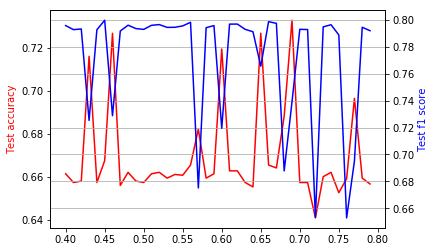

In [327]:
import matplotlib.pyplot as plt

best_acc = np.argmax(test_acc)
print(lr[best_acc])
print('accuracy', test_acc[best_acc])
print('f1', test_f1[best_acc])

best_f1 = np.argmax(test_f1)
print(lr[best_f1])
print('accuracy', test_acc[best_f1])
print('f1', test_f1[best_f1])

fig, ax1 = plt.subplots()
#ax1.title('Test results over learning rate')

ax1.plot(lr, test_acc, color='r')
ax1.set_ylabel('Test accuracy', color='r')

ax2 = ax1.twinx()
ax2.plot(lr, test_f1, color='b')
ax2.set_ylabel('Test f1 score', color='b')

plt.grid()

In [560]:
# Fix the seeds to get consistent results
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

INPUT_DIM = len(word2idx_a)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
#the hyperparamerts specific to CNN
# we define the number of filters
N_OUT_CHANNELS = 1
# we define the window size
WINDOW_SIZE = 1
mymodel_a = MyModel(INPUT_DIM, EMBEDDING_DIM, N_OUT_CHANNELS).to('cuda')
mymodel_a.apply(init_weights)
mymodel_a.embedding.weight.data.copy_(torch.from_numpy(wvecs))

optimizer = optim.RMSprop(mymodel_a.parameters(), lr=0.69*3e-3,weight_decay=1e-7)
loss_fn = nn.BCEWithLogitsLoss()

train_model(mymodel_a, train_a_loader, valid_a_loader, test_a_loader)

Epoch: 1. Train Loss: 0.641. Train Accuracy: 67.017  Val. Loss: 0.627 Val. Acc: 68.037
Epoch: 2. Train Loss: 0.635. Train Accuracy: 67.017  Val. Loss: 0.632 Val. Acc: 67.630
Epoch: 3. Train Loss: 0.632. Train Accuracy: 67.395  Val. Loss: 0.647 Val. Acc: 67.155
Epoch: 4. Train Loss: 0.638. Train Accuracy: 66.638  Val. Loss: 0.632 Val. Acc: 67.359
Epoch: 5. Train Loss: 0.637. Train Accuracy: 66.638  Val. Loss: 0.629 Val. Acc: 67.901
Epoch: 6. Train Loss: 0.635. Train Accuracy: 67.029  Val. Loss: 0.628 Val. Acc: 67.901
Epoch: 7. Train Loss: 0.632. Train Accuracy: 67.407  Val. Loss: 0.634 Val. Acc: 67.698
Epoch: 8. Train Loss: 0.643. Train Accuracy: 65.894  Val. Loss: 0.640 Val. Acc: 67.291
Epoch: 9. Train Loss: 0.632. Train Accuracy: 67.407  Val. Loss: 0.627 Val. Acc: 68.104
Epoch: 10. Train Loss: 0.630. Train Accuracy: 67.786  Val. Loss: 0.632 Val. Acc: 67.562
Epoch: 11. Train Loss: 0.634. Train Accuracy: 67.029  Val. Loss: 0.626 Val. Acc: 68.172
Epoch: 12. Train Loss: 0.634. Train Accur

(0.7321797555143182, 0.7661534267592857)

In [561]:
# Fix the seeds to get consistent results
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True



INPUT_DIM = len(word2idx_a)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
#the hyperparamerts specific to CNN
# we define the number of filters
N_OUT_CHANNELS = 1
# we define the window size
WINDOW_SIZE = 1
mymodel_b = MyModel(INPUT_DIM, EMBEDDING_DIM, N_OUT_CHANNELS).to('cuda')
mymodel_b.apply(init_weights)
mymodel_b.embedding.weight.data.copy_(torch.from_numpy(wvecs))

optimizer = optim.Adam(mymodel_b.parameters(), lr=689e-5)
loss_fn = nn.BCEWithLogitsLoss()

train_model(mymodel_b, train_b_loader, valid_b_loader, test_b_loader)

Epoch: 1. Train Loss: 0.694. Train Accuracy: 49.837  Val. Loss: 0.693 Val. Acc: 48.422
Epoch: 2. Train Loss: 0.694. Train Accuracy: 49.878  Val. Loss: 0.693 Val. Acc: 49.442
Epoch: 3. Train Loss: 0.694. Train Accuracy: 50.347  Val. Loss: 0.695 Val. Acc: 49.442
Epoch: 4. Train Loss: 0.694. Train Accuracy: 49.736  Val. Loss: 0.693 Val. Acc: 49.609
Epoch: 5. Train Loss: 0.694. Train Accuracy: 49.981  Val. Loss: 0.695 Val. Acc: 50.574
Epoch: 6. Train Loss: 0.693. Train Accuracy: 50.286  Val. Loss: 0.693 Val. Acc: 50.574
Epoch: 7. Train Loss: 0.693. Train Accuracy: 49.777  Val. Loss: 0.691 Val. Acc: 46.716
Epoch: 8. Train Loss: 0.693. Train Accuracy: 50.388  Val. Loss: 0.692 Val. Acc: 50.574
Epoch: 9. Train Loss: 0.693. Train Accuracy: 49.981  Val. Loss: 0.693 Val. Acc: 48.645
Epoch: 10. Train Loss: 0.681. Train Accuracy: 50.697  Val. Loss: 0.656 Val. Acc: 61.878
Epoch: 11. Train Loss: 0.588. Train Accuracy: 70.161  Val. Loss: 0.621 Val. Acc: 66.661
Epoch: 12. Train Loss: 0.519. Train Accur

(0.9581473214285714, 0.9582222874625943)

In [359]:
 def accuracy_c(output, target):
    correct = torch.sum(torch.argmax(output, dim = 1).float() == target.float(), dtype = torch.float)
    acc = correct / len(target)
 
    return acc

In [360]:
def f_measure_c(output, gold):

    output = torch.argmax(output, dim = 1)
    output = output.cpu().numpy()
    gold = gold.cpu().numpy()

    recall, precision, fscore, _ = precision_recall_fscore_support(output, gold, labels=[0, 1, 2])
    recall_m, precision_m, fscore_m, _ = precision_recall_fscore_support(output, gold, labels=[0, 1, 2], average='macro')
    
    return np.append(recall, recall_m), np.append(precision, precision_m), np.append(fscore, fscore_m)

In [465]:
def train_model_c(model, train_loader, valid_loader, test_loader):  
    for epoch in range(1, epochs+1):
        
        epoch_loss = 0
        epoch_acc = 0
        valid_loss = 0
        valid_acc = 0
        test_loss = 0
        test_acc = 0
        model.train()
        
        recall = 0
        precision = 0
        fscore = 0
        
        count_train = 0
        count_valid = 0
        count_test = 0
       
        #iterate over batches
        for batch in train_loader:
            
            #place on the GPU
            #feature, target = batch.text.cuda(), batch.label.cuda()
            
            feature, target = batch
            
            feature = feature.to('cuda')
            target = target.to('cuda')
 
            optimizer.zero_grad()
            predictions = model(feature).squeeze(1)
             
            loss = loss_fn(predictions, target.long())
            acc = accuracy_c(predictions, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            count_train += 1
        
        with torch.no_grad():
            for batch_valid in valid_loader:
                feature_valid, target_valid = batch_valid
                
                feature_valid = feature_valid.to('cuda')
                target_valid = target_valid.to('cuda')
                
                predictions_valid = model(feature_valid).squeeze(1)
                loss = loss_fn(predictions_valid, target_valid.long())
                acc = accuracy_c(predictions_valid, target_valid)
                valid_loss += loss.item()
                valid_acc += acc.item()
                count_valid += 1
            
        valid_loss = valid_loss /count_valid
        valid_acc = valid_acc /count_valid
        epoch_loss = epoch_loss /count_train
        epoch_acc = epoch_acc /count_train
        
        print('Epoch: {}. Train Loss: {:.3f}. Train Accuracy: {:.3f}  Val. Loss: {:.3f} Val. Acc: {:.3f}'.format(epoch, epoch_loss, epoch_acc*100, valid_loss, valid_acc*100))
        
        valid_loss = 0
        valid_acc = 0
        epoch_loss = 0
        epoch_acc = 0
    
    with torch.no_grad():
        for batch_test in test_loader:
            feature_test, target_test = batch_test
            
            feature_test = feature_test.to('cuda')
            target_test = target_test.to('cuda')
            
            predictions_test = model(feature_test).squeeze(1)
            loss = loss_fn(predictions_test, target_test.long())
            acc = accuracy_c(predictions_test, target_test)
            test_loss += loss.item()
            test_acc += acc.item()
            
            r, p, f = f_measure_c(predictions_test, target_test)
            recall += r
            precision += p
            fscore += f
            count_test += 1

    test_loss = test_loss /count_test
    test_acc = test_acc /count_test
    recall = recall /count_test
    precision = precision /count_test
    fscore = fscore /count_test

    print('Test Loss: {:.3f}. Test Accuracy: {:.3f}'.format(test_loss, test_acc*100))
    print("Class 0: Recall: %.2f, Precision: %.2f, F-measure: %.2f\n" % (recall[0], precision[0], fscore[0]))
    print("Class 1: Recall: %.2f, Precision: %.2f, F-measure: %.2f\n" % (recall[1], precision[1], fscore[1]))
    print("Class 2: Recall: %.2f, Precision: %.2f, F-measure: %.2f\n" % (recall[2], precision[2], fscore[2]))
    print("Macro: Recall: %.2f, Precision: %.2f, F-measure: %.2f\n" % (recall[3], precision[3], fscore[3]))

In [562]:
# Fix the seeds to get consistent results
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Train method, not adapted yet

INPUT_DIM = len(word2idx_a)
EMBEDDING_DIM = 100
OUTPUT_DIM = 3
#the hyperparamerts specific to CNN
# we define the number of filters
N_OUT_CHANNELS = 3
# we define the window size
WINDOW_SIZE = 1
mymodel_c = MyModel(INPUT_DIM, EMBEDDING_DIM, N_OUT_CHANNELS).to('cuda')
mymodel_c.apply(init_weights)
mymodel_c.embedding.weight.data.copy_(torch.from_numpy(wvecs))

optimizer = optim.RMSprop(mymodel_c.parameters(), lr = 1138e-5)
loss_fn = nn.CrossEntropyLoss()

train_model_c(mymodel_c, train_c_loader, valid_c_loader, test_c_loader)

Epoch: 1. Train Loss: 1.157. Train Accuracy: 41.037  Val. Loss: 0.957 Val. Acc: 50.985
Epoch: 2. Train Loss: 0.763. Train Accuracy: 69.011  Val. Loss: 0.598 Val. Acc: 76.961
Epoch: 3. Train Loss: 0.391. Train Accuracy: 87.120  Val. Loss: 0.459 Val. Acc: 82.644
Epoch: 4. Train Loss: 0.198. Train Accuracy: 94.671  Val. Loss: 0.410 Val. Acc: 84.342
Epoch: 5. Train Loss: 0.099. Train Accuracy: 97.717  Val. Loss: 0.404 Val. Acc: 85.647
Epoch: 6. Train Loss: 0.057. Train Accuracy: 98.667  Val. Loss: 0.386 Val. Acc: 87.046
Epoch: 7. Train Loss: 0.037. Train Accuracy: 99.234  Val. Loss: 0.438 Val. Acc: 85.472
Epoch: 8. Train Loss: 0.027. Train Accuracy: 99.472  Val. Loss: 0.422 Val. Acc: 87.001
Epoch: 9. Train Loss: 0.022. Train Accuracy: 99.581  Val. Loss: 0.456 Val. Acc: 86.103
Epoch: 10. Train Loss: 0.020. Train Accuracy: 99.586  Val. Loss: 0.434 Val. Acc: 85.585
Epoch: 11. Train Loss: 0.015. Train Accuracy: 99.768  Val. Loss: 0.482 Val. Acc: 86.119
Epoch: 12. Train Loss: 0.013. Train Accur

In [603]:
# Get predictions of test data for submission
predictions_eva_a = []
predictions_eva_b = []
predictions_eva_c = []

with torch.no_grad():
    feature_eva_a = eva_data_a.to('cuda')
    predictions_eva_a.append(mymodel_a(feature_eva_a))
    
    feature_eva_b = eva_data_b.to('cuda')
    predictions_eva_b.append(mymodel_b(feature_eva_b))
    
    feature_eva_c = eva_data_c.to('cuda')
    predictions_eva_c.append(mymodel_c(feature_eva_c))

In [604]:
predict_results_a = predictions_eva_a[0].cpu().numpy().flatten()
predict_results_b = predictions_eva_b[0].cpu().numpy().flatten()
predict_results_c = predictions_eva_c[0].cpu().numpy()

In [595]:
# Assign labels and write csv
predict_label_a = np.empty(len(predict_results_a), dtype = object)

predict_label_a[predict_results_a < 0.5] = "NOT"
predict_label_a[predict_results_a >= 0.5] = "OFF"

df_a = pd.DataFrame({'Id':eva_id_a, 'Label':predict_label_a})
df_a.to_csv('task_a_results.csv', index=False, header = False)

predict_label_b = np.empty(len(predict_results_b), dtype = object)

predict_label_b[predict_results_b < 0.5] = "TIN"
predict_label_b[predict_results_b >= 0.5] = "UNT"

df_b = pd.DataFrame({'Id':eva_id_b, 'Label':predict_label_b})
df_b.to_csv('task_b_results.csv', index=False, header = False)

In [609]:
predict_label_c = np.empty(len(predict_results_c), dtype = object)

predict_label_c[np.argmax(predict_results_c, axis = 1) == 0] = "GRP"
predict_label_c[np.argmax(predict_results_c, axis = 1) == 1] = "IND"
predict_label_c[np.argmax(predict_results_c, axis = 1) == 2] = "OTH"

df_c = pd.DataFrame({'Id':eva_id_c, 'Label':predict_label_c})
df_c.to_csv('task_c_results.csv', index=False, header = False)